In [143]:
import matplotlib.pyplot as plt

In [153]:
import os
import argparse
from ast import literal_eval
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from dateutil import parser

import pandas as pd
import numpy as np

from run import create_model
import config
from src.tests import acc_ir, plot_ir

conf = config.get_config()
df = pd.read_csv(conf['database'])

# Only take the once with 200 iterations
# df = df[df.num_steps == 200]

# Parse arrays
df['incumbent'] = df.incumbent.fillna('None').apply(literal_eval)
df['immediate_regret'] = df.immediate_regret.fillna('None').apply(literal_eval)
df.date = df.date.astype('datetime64[ns]')

# Remove invalid seeds (set default seed)
df.loc[df.seed == -1, 'seed'] = 0

# Remove dublicates
df = df.sort_values(by=['date'])
df = df.groupby(["uuid"]).agg(lambda x: x.iloc[0]).reset_index()
df = df.sort_values(by=['date'])

# Make embedding into tuples to support hashing (used in groupby)
df.embedding = df.embedding.fillna('[]')
df.embedding = df.embedding.apply(literal_eval)
df.embedding = [ tuple(row.embedding) for _, row in df.iterrows() ]

def get_model_conf(uid):
    row = df_indexed.loc[uid]
    model_shortname = row['name']
    model_conf = config.get_model_config(uid, model_shortname, conf)
    return model_conf

def plot_ir_image(model_conf):
    display(Image(filename=model_conf['regret_plot_path']))

def plot_step_image(model_conf):
    # l = os.listdir(model_conf['plot_folder'])
    l_all = glob.glob(os.path.join(model_conf['plot_folder'], '*.png'))
    l_all.sort(key=lambda n: int(n.replace(".", "-").split('-')[-2]))
    l_em = [img for img in l_all if "embedding" in img]
    l = [img for img in l_all if "embedding" not in img]

    def show_image(i):
        if i < len(l):
            display(Image(filename=l[i]))
        if i < len(l_em):
            display(Image(filename=l_em[i]))
    
    length = max(len(l), len(l_em))
    # Only if there are images
    if length > 0:
        interact(show_image, i=widgets.IntSlider(min=0, max=length - 1, step=1, value=0))

def get_XY(model_conf):
    X = np.load(model_conf['obs_X_path'])
    Y = np.load(model_conf['obs_Y_path'])
    return X, Y
    
def recreate_model(uid, model_conf, train=True, extra_args=None):
    args_dict = df_indexed.loc[uid].to_dict()
    if extra_args is not None:
        args_dict.update(extra_args)
        
    args = argparse.Namespace(**args_dict)
    args.batch_size = int(args.batch_size) # quick fix
    args.seed = int(args.seed)             # quick fix
        
    bo = create_model(args)
    X,Y = get_XY(model_conf)
    bo.model.init(X, Y, train=train)
    return bo

# Delete seedless
df = df.drop(df[(df.date < parser.parse("2018-08-19 15:00")) & (df.date > parser.parse("2018-08-19 13:00"))].index, axis=0)

#df = df[df.date < parser.parse("2018-08-19 15:00")]                                                    # pre weekend (funcs)
#df = df[(df.date > parser.parse("2018-08-19 15:00")) & (df.date < parser.parse("2018-08-20 14:15"))]   # weekend (extended) (props)
#df = df[(df.date > parser.parse("2018-08-20 14:15"))]                                                  # post weekend

GROUP = 'ensemble_size'
print(df.group.unique())
df = df[df.group == GROUP]

for col in ['seed', 'dim_basis', 'dim_h1', 'dim_h2', 'num_nn', 'batch_size', 'epochs', 'num_mcmc', 'n_iter', 'n_init']:
    df[col] = df[col].astype(int)
for col in ['lr', 'weight_decay']:
    df[col] = df[col].astype(float)

# OBS: Global variable used by function!
df_indexed = df.set_index('uuid')

df

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


uuid  acq  batch_size                       date  dim_basis  dim_h1  \
75  daf1cca2  UCB        1000 2018-08-21 10:46:10.912144         50      50   
13  26cc72d0  UCB        1000 2018-08-21 10:46:10.982763         50      50   
60  9969018d  UCB        1000 2018-08-21 10:46:11.030188         50      50   
45  74a216ca  UCB        1000 2018-08-21 10:46:12.191742         50      50   
16  2fa984ef  UCB        1000 2018-08-21 10:46:12.389382         50      50   

    dim_h2 embedding  epochs          group      ...      n_init n_iter  \
75      50        ()    1000  ensemble_size      ...          20    200   
13      50        ()    1000  ensemble_size      ...          20    200   
60      50        ()    1000  ensemble_size      ...          20    200   
45      50        ()    1000  ensemble_size      ...          20    200   
16      50        ()    1000  ensemble_size      ...          20    200   

                                                 name nn_aggregator  num_mcmc  \
75  daf1cca2--g-ensemble_size-s-1-m-dngo-init-20-k...           max         0   
13  26cc72d0--g-ensemble_size-s-1-m-dngo-init-20-k...        median         0   
60  9969018d--g-ensemble_size-s-1-m-dngo-init-20-k...           max         0   
45  74a216ca--g-ensemble_size-s-1-m-dngo-init-20-k...           max         0   
16  2fa984ef--g-ensemble_size-s-1-m-dngo-init-20-k...        median         0   

    num_nn num_steps obj_func  seed  weight_decay  
75       5     200.0   branin     1           0.0  
13      15     180.0   branin     1           0.0  
60      10     200.0   branin     1           0.0  
45      15     170.0   branin     1           0.0  
16      10     200.0   branin     1           0.0  

[5 rows x 24 columns]

In [154]:
% matplotlib inline

import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [155]:
import itertools
uuid_keys = ['acq', 'batch_size', 'dim_basis', 'dim_h1', 'dim_h2',
             'epochs', 'lr', 'model', 'n_iter', 'nn_aggregator', 'num_mcmc', 'num_nn',
             'weight_decay', 'obj_func', 'embedding']

def get_regret_history(uids):
    max_hist = []
    for uid in uids:
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        maxy = np.maximum.accumulate(bo.model.Y)

        # Remove output dimension
        maxy = maxy[:,0]

        max_hist.append(maxy)
    # Fills arrays of different length with NaN
    max_hist = np.array(list(itertools.zip_longest(*max_hist, fillvalue=np.nan))).T
    
    mean = np.nanmean(max_hist, axis=0)

    var = np.nanvar(max_hist, axis=0)
    # top = np.maximum(mean + np.sqrt(var), bo.f_opt)
    # bottom = np.maximum(mean - np.sqrt(var), bo.f_opt)
    return np.abs(mean + np.sqrt(var) - bo.f_opt), np.abs(mean - bo.f_opt), np.abs(mean - np.sqrt(var) - bo.f_opt), max_hist

gf = df.groupby(uuid_keys)
df_agg = gf.agg(list).reset_index()
df_agg['regret_history'] = df_agg.uuid.apply(get_regret_history)

reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances


# Regret Comparer

In [156]:
from src.utils import random_hypercube_samples

def show_ir(obj_func):
    model_rows = df_agg[(df_agg.obj_func == obj_func)]

    # Rand hist
    uid = model_rows.iloc[0].uuid[0]
    model_conf = get_model_conf(uid)
    bo = recreate_model(uid, model_conf, train=False)
    rand_hist = bo.obj_func(random_hypercube_samples(bo.n_init + bo.n_iter, bo.bounds, rng=bo.rng))
    plt.plot(acc_ir(rand_hist, bo.f_opt), label="rand")
    plt.fill_between([],[],[])
    
    for i, row in model_rows.iterrows():
        # mean, var, originals = row['regret_history']
        top, mean, bottom, originals = row['regret_history']
        plt.plot(mean, label=row['name'][0])
        # plt.fill_between(np.arange(mean.shape[0]), mean + np.sqrt(var), mean - np.sqrt(var), alpha=.2)
        plt.fill_between(np.arange(mean.shape[0]), top, bottom, alpha=.2)
        #for orig in originals[:1]:
        #    plt.plot(orig)
        #break
    plt.yscale('log')
    plt.legend()

interact(show_ir, obj_func=df_agg.obj_func.unique())

interactive(children=(Dropdown(description='obj_func', options=('branin',), value='branin'), Output()), _dom_c…

<function __main__.show_ir(obj_func)>

- Forrester: Note weird rounding error for dngo-nn-5-agg-max leading to increase in otherwise monotone decreasing regret..

In [116]:
# Quick plot
from src.tests import acc_ir, plot_ir

def show_prediction(obj_func, embedded):
    model_rows = df_agg[(df_agg.obj_func == obj_func)]
    hist = []
    legends = []
    for i, row in model_rows.iterrows():
        uid = row.uuid[0]
        name = row['name'][0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        print("Model:", name)
        bo.plot_prediction(plot_predictions=False, plot_embedded_subspace=embedded)

interact(show_prediction, obj_func=df_agg.obj_func.unique(), embedded=False)

interactive(children=(Dropdown(description='obj_func', options=('sinone', 'branin'), value='sinone'), Checkbox…

<function __main__.show_prediction(obj_func, embedded)>

In [120]:
from src.tests import acc_ir, plot_ir

def show_prediction(obj_func, embedded):
    if None:
        return
    model_rows = df_agg[(df_agg.obj_func == obj_func)]

    for i, row in model_rows.iterrows():
        uid = row.uuid[0]
        name = row['name'][0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000))
        print("Model:", name)
        #bo.embedded_dims is not None
        bo.plot_prediction(plot_embedded_subspace=embedded)

interact(show_prediction, obj_func=[None] + list(df_agg.obj_func.unique()), embedded=False)

interactive(children=(Dropdown(description='obj_func', options=(None, 'sinone', 'branin'), value=None), Checkb…

<function __main__.show_prediction(obj_func, embedded)>

# Specific model explorer

In [5]:
def plot(uid):
    model_conf = get_model_conf(uid)
    try:
        plot_step_image(model_conf)
        plot_ir_image(model_conf)
    except Exception as e:
        print(e)
    return uid, model_conf

# multiple selection (num_nn, agg, model, obj_func) -> select from what is left
widget = interactive(plot, uid=list(zip(df.name, df.uuid)))
display(widget)

interactive(children=(Dropdown(description='uid', options=(('ce34ca74--s-1-m-dngo-init-20-k-200-e-100-f-levy',…

In [19]:
uid, model_conf = widget.result
bo = recreate_model(uid, model_conf)

reconstraining parameters linear.variances
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


 /Users/tmpethick/GoogleDrive/dtu/8-5-ETH-summer/eth-project/src/models.py:170: RuntimeWarning:invalid value encountered in sqrt
 /Users/tmpethick/GoogleDrive/dtu/8-5-ETH-summer/eth-project/src/acquisition_functions.py:28: RuntimeWarning:invalid value encountered in sqrt


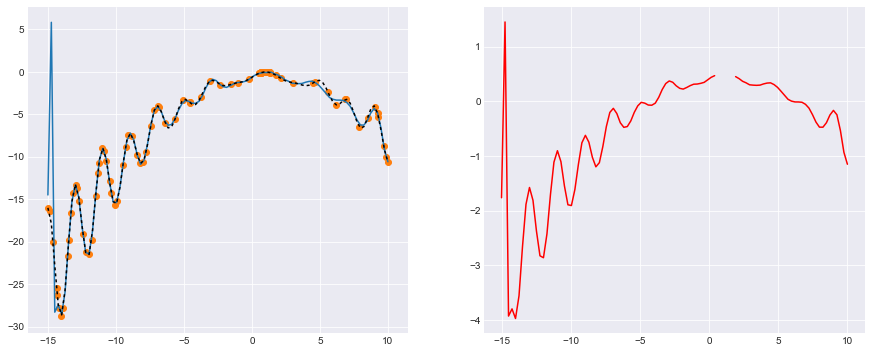

In [20]:
bo.plot_prediction()

In [84]:

fig = bo.plot_2D_surface(use_plotly=True)
iplot(fig)

This is the format of your plot grid:
[ (1,1) scene1 ]  [ (1,2) scene2 ]
[ (2,1) scene3 ]  [ (2,2) scene4 ]



# Acqusition function debugging for emsamble

reconstraining parameters linear.variances
/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

divide by zero encountered in log

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:119: RuntimeWarning:

overflow encountered in expm1

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:121: RuntimeWarning:

overflow encountered in expm1



Model: 20cce47c--s-1-m-dngo-init-20-k-200-em-0-f-sinone
(100, 2)


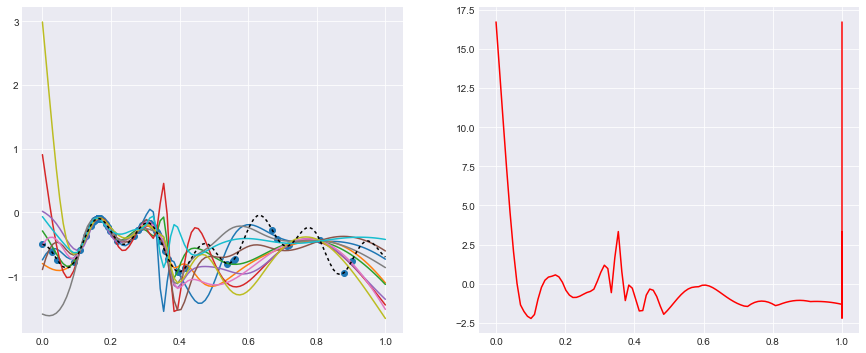

(100, 2)


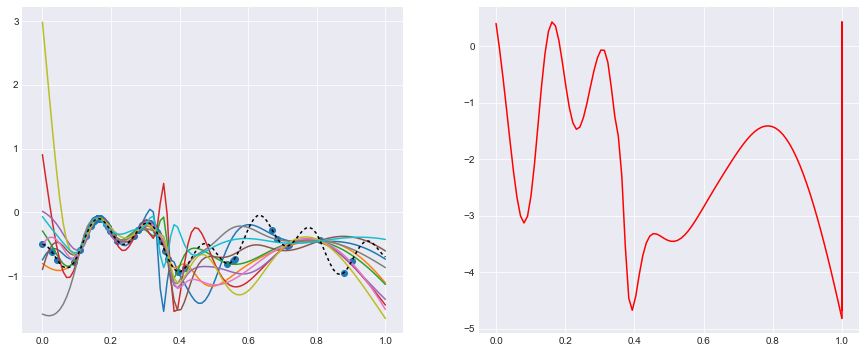

In [5]:
uid = '20cce47c'
name = df_indexed.loc[uid, 'name']
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=100, batch_size=10, lr=0.001, weight_decay=0.000, nn_aggregator='max'))
print("Model:", name)
bo.plot_prediction(plot_embedded_subspace=bo.embedded_dims is not None)
bo.model.ensemble_aggregator = np.mean
bo.plot_prediction(plot_embedded_subspace=bo.embedded_dims is not None)

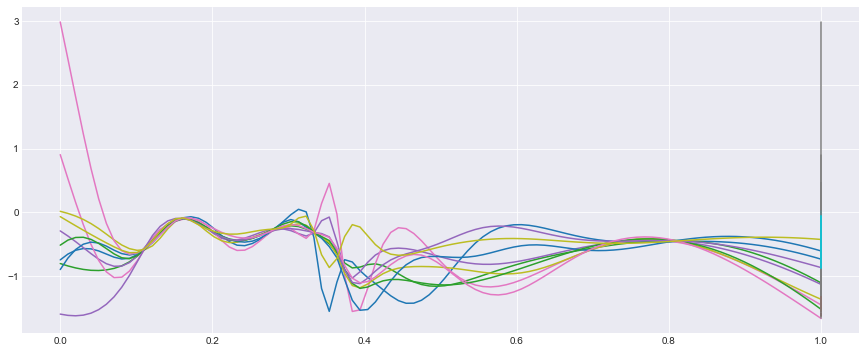

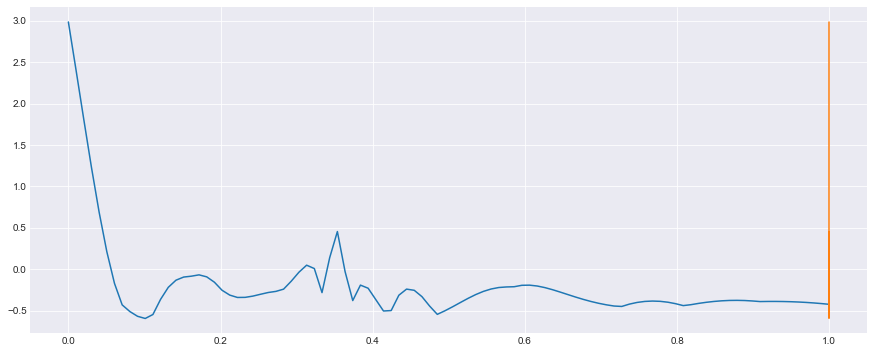

In [6]:
x = np.append(np.linspace(0,1,100)[:,None], np.ones((100,1)), axis=1)
Ds = bo.model.predict(x)

for i in range(Ds.shape[0]):
    plt.plot(x, Ds[i,0,0,:])
plt.show()
plt.plot(x, np.max(Ds[:,0,0,:], axis=0))

# Logisic Regression Test

In [1]:
%load_ext autoreload
%autoreload 2

from src.logistic_regression_benchmark import LogisticRegression

In [319]:
reg = LogisticRegression()
#reg.run()